# Import libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Import processed dataset

In [7]:
loc = os.path.normpath(os.getcwd() + os.sep + os.pardir)
dataset_link = loc + '\processed_data'

In [8]:
df = pd.read_csv(dataset_link + r'\order_customer.csv', index_col='order_purchase_timestamp', parse_dates=True)
df

,order_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
order_purchase_timestamp,,,,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...
2017-03-09 09:54:05,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
2018-02-06 12:58:58,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
2017-08-27 14:46:43,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA


# Aggregate data

Only get data from 2017-01-01 to 2017-11-01 to avoid anomaly from Black Friday

In [9]:
df = df['order_id'].resample('D').count()
df = pd.DataFrame(df.loc['2017-01-01':'2017-11-01'])
df

,order_id
order_purchase_timestamp,
2017-01-01,0
2017-01-02,0
2017-01-03,0
2017-01-04,0
2017-01-05,32
...,...
2017-10-28,88
2017-10-29,132
2017-10-30,149


Create train and test set

In [10]:
train_data = df.iloc[:225]
test_data = df.iloc[225:]

In [11]:
train_data.tail()

,order_id
order_purchase_timestamp,
2017-08-09,144
2017-08-10,157
2017-08-11,141
2017-08-12,98
2017-08-13,96


In [12]:
test_data.head()

,order_id
order_purchase_timestamp,
2017-08-14,159
2017-08-15,194
2017-08-16,174
2017-08-17,158
2017-08-18,147


# Create model

In [13]:
fitted_model = ExponentialSmoothing(train_data['order_id'],
                                   trend='add', seasonal='add',
                                   seasonal_periods=7).fit()
# trend='mul',seasonal='mul', seasonal_periods=7
test_predictions = fitted_model.forecast(80)
test_predictions

2017-08-14    152.266923
2017-08-15    153.270211
2017-08-16    141.319105
2017-08-17    140.011483
2017-08-18    130.739307
                 ...    
2017-10-28    143.402348
2017-10-29    160.076157
2017-10-30    196.879152
2017-10-31    197.882440
2017-11-01    185.931334
Freq: D, Length: 80, dtype: float64

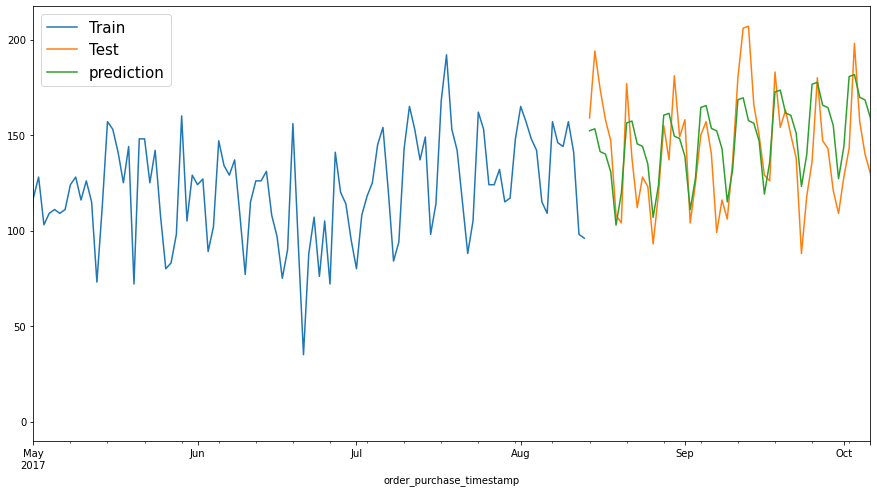

In [14]:
# Visualize
train_data['order_id'].plot(legend=True, label='Train', figsize=(15,8))
test_data['order_id'].plot(legend=True, label='Test')
test_predictions.plot(legend=True ,label='prediction',
                      xlim=['2017-05-01', '2017-10-06'])
plt.legend(fontsize=15) 

# Evaluate model

In [15]:
mean_squared_error(test_data, test_predictions)

647.5229244722987

In [16]:
mean_absolute_error(test_data, test_predictions)

20.656400825709106

In [17]:
np.sqrt(mean_squared_error(test_data, test_predictions))

25.446471748992995